# Hotspots

Hotspots California map: 
- Wildifre-wildifreSmokePM2.5, 
- Heat-wildfire,
- Heat-PM2.5, 
- Wildifre-Heat-SmokePM2.5P

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("outputs/merged_heatday_coldday_wfday_polluted_smoke_polluted_rolling.parquet")

In [ ]:
df = df.drop(columns = ['tmin','tmax','pm25','smoke_pm'])

In [3]:
df.head()

,index,time,tmax,tmin,rhum,wfday,pm25,FIPS_1,GEOID,smoke_pm,heatday,coldday,polluted,smoke_pm_non_zero,smoke_pm_gt_five
0,0,2006-01-01,16.850000,11.850000,99.300003,False,3.784,6071010032,6071010032,0.0,False,False,False,False,False
1,1,2006-01-02,18.749994,8.850000,100.000000,False,6.400,6071010032,6071010032,0.0,False,False,False,False,False
2,2,2006-01-03,22.950006,7.950006,88.900002,False,11.912,6071010032,6071010032,0.0,False,False,False,False,False
3,3,2006-01-04,28.749994,12.850000,55.500000,False,6.392,6071010032,6071010032,0.0,True,False,False,False,False
4,4,2006-01-05,28.850000,12.649988,22.500000,False,10.996,6071010032,6071010032,0.0,True,False,False,False,False


### Find hotspots

Terminology:
- h heat
- w wildfire
- p polluted
- s smoke polluted

Example:
- hwp is a hotspot where heat wildfire and pollution are co-occuring 

In [4]:
df.columns

Index(['index', 'time', 'tmax', 'tmin', 'rhum', 'wfday', 'pm25', 'FIPS_1',
       'GEOID', 'smoke_pm', 'heatday', 'coldday', 'polluted',
       'smoke_pm_non_zero', 'smoke_pm_gt_five'],
      dtype='object')

In [5]:
df['hw'] = df['wfday'] & df['heatday']
df['hp'] = df['heatday'] & df['polluted']
df['hwp'] = df['heatday'] & df['wfday'] & df['polluted']

In [6]:
# helper column
df['hwps'] = df[['heatday','wfday','polluted','smoke_pm_non_zero']].sum(axis=1)

In [7]:
# smoke_pm_non_zero taken as main

df['hs'] = df['heatday'] & df['smoke_pm_non_zero']
df['hws'] = df['heatday'] & df['wfday'] & df['smoke_pm_non_zero']
df['ws'] = df['wfday'] & df['smoke_pm_non_zero']

In [8]:
df['hs5'] = df['heatday'] & df['smoke_pm_gt_five']
df['hws5'] = df['heatday'] & df['wfday'] & df['smoke_pm_gt_five']
df['ws5'] = df['wfday'] & df['smoke_pm_gt_five']

In [11]:
df = df.drop(columns=['index', 'FIPS_1'])

In [12]:
df.to_parquet("outputs/hotspots_per_fips_rolling.parquet")

## Hotspot trends over time on Census Tract

In [3]:
df = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")

In [13]:
trends_df = (
    df.groupby("GEOID")[
        [
            "time",
            "ws",
            "hw",
            "hp",
            "hs",
            "hwp",
            "hws",
            "hwps",
            "wfday",
            "hs5",
            "hws5",
            "ws5",
            "heatday",
            "coldday",
            "polluted",
            "smoke_pm_non_zero",
            "smoke_pm_gt_five",
        ]
    ]
    .resample("Y", on="time")
    .sum()
)

In [14]:
trends_df.head()

ws  hw  hp  hs  hwp  hws  hwps  wfday  hs5  hws5  ws5  \
GEOID      time                                                                
6001400100 2006-12-31   0   0   0   1    0    0    35      0    0     0    0   
           2007-12-31   0   0   0   0    0    0    25      0    0     0    0   
           2008-12-31   0   0   0   8    0    0    73      0    4     0    0   
           2009-12-31   0   0   0   4    0    0    34      0    2     0    0   
           2010-12-31   0   0   0   2    0    0    29      0    0     0    0   

                       heatday  coldday  polluted  smoke_pm_non_zero  \
GEOID      time                                                        
6001400100 2006-12-31       15       19         0                 20   
           2007-12-31       12       23         0                 13   
           2008-12-31       24       12         2                 47   
           2009-12-31       22       17         0                 12   
           2010-12-31       18       11         0                 11   

                       smoke_pm_gt_five  
GEOID      time                          
6001400100 2006-12-31                 2  
           2007-12-31                 3  
           2008-12-31                23  
           2009-12-31                 4  
           2010-12-31                 0

In [15]:
%load_ext lab_black

In [20]:
import plotting

%load_ext autoreload
%autoreload 2
hs_dict = plotting.get_hotspopt_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
trends_df = trends_df.reset_index()

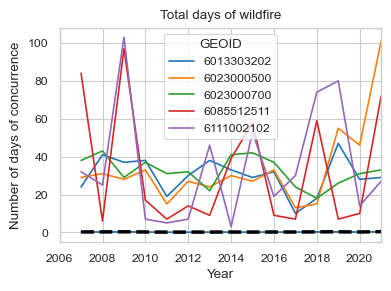

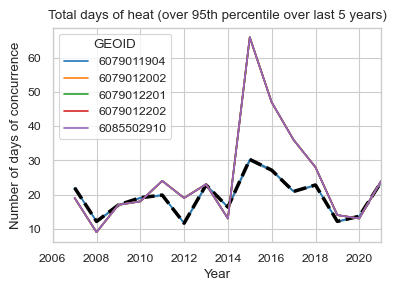

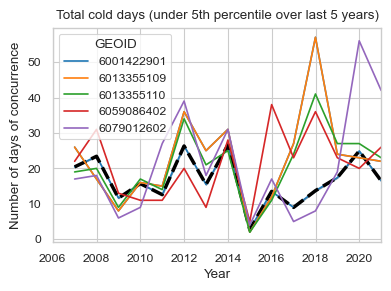

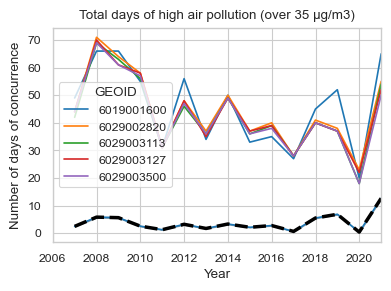

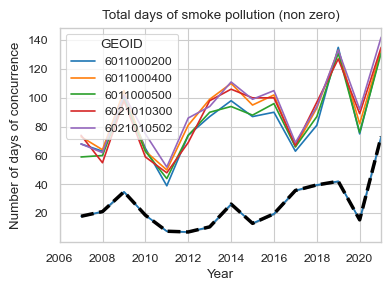

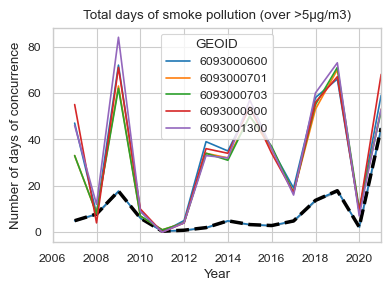

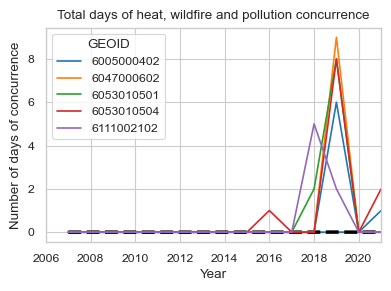

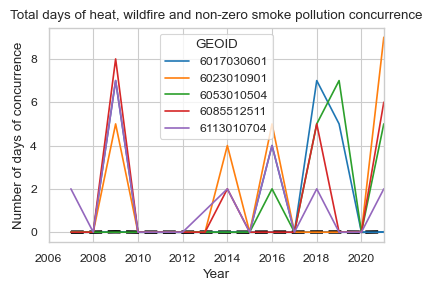

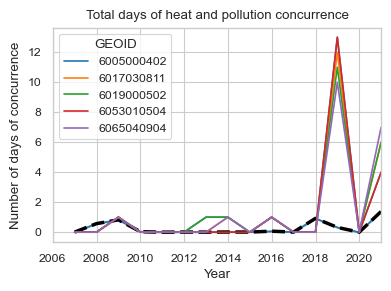

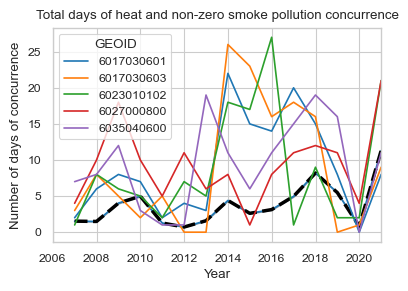

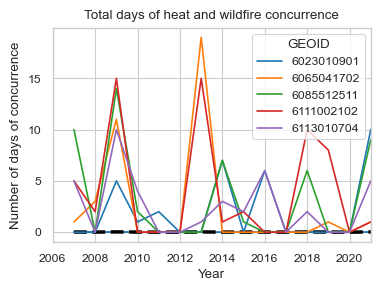

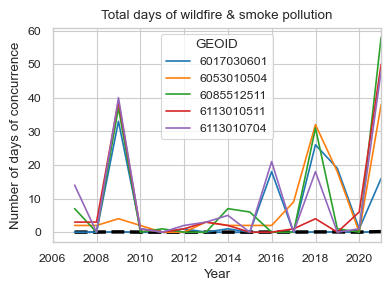

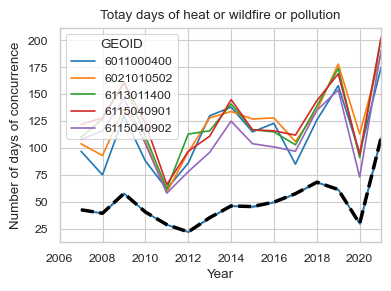

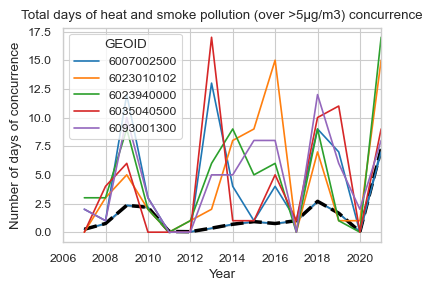

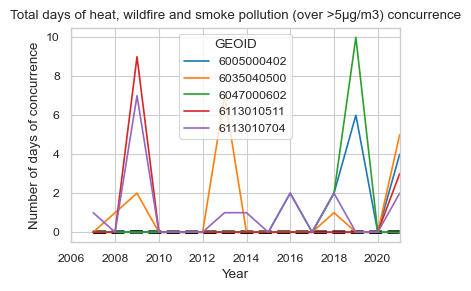

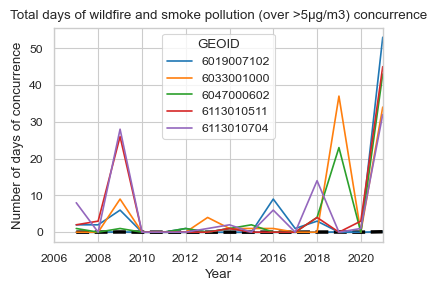

In [21]:
for x in hs_dict.keys():
    l = trends_df.groupby("GEOID")[x].sum().sort_values().tail(5).index

    plotting.trend_plot(trends_df, l, x, hs_dict[x]["title"], hs_dict[x]["title_map"])

### Wildfire-Heat-PM25

In [22]:
import geopandas as gpd

In [23]:
gdf = gpd.read_file("data/esri/FIPSMapping.gdb")

In [27]:
gdf["FIPS_1"] = gdf.FIPS_1.astype(int)

In [42]:
merged_df = df

In [43]:
merged_df = merged_df[
    [
        "GEOID",
        "heatday",
        "wfday",
        "coldday",
        "polluted",
        "smoke_pm_non_zero",
        "smoke_pm_gt_five",
        "hw",
        "hp",
        "hwp",
        "hwps",
        "hs",
        "hws",
        "ws",
        "hs5",
        "hws5",
        "ws5",
    ]
]

In [44]:
merged_df = merged_df.groupby("GEOID").sum()

In [45]:
merged_df = merged_df.reset_index()

In [46]:
merged_df.head()

,GEOID,heatday,wfday,coldday,polluted,smoke_pm_non_zero,smoke_pm_gt_five,hw,hp,hwp,hwps,hs,hws,ws,hs5,hws5,ws5
0,6001400100,289,0,228,34,433,134,0,7,0,756,61,0,0,25,0,0
1,6001400200,300,0,242,54,410,136,0,8,0,764,50,0,0,20,0,0
2,6001400300,300,0,242,54,410,136,0,8,0,764,50,0,0,20,0,0
3,6001400400,300,0,242,48,410,136,0,8,0,758,50,0,0,20,0,0
4,6001400500,300,0,242,54,410,136,0,8,0,764,50,0,0,20,0,0


In [47]:
temp = gdf.merge(merged_df, left_on="FIPS_1", right_on="GEOID")

In [48]:
import matplotlib.pyplot as plt

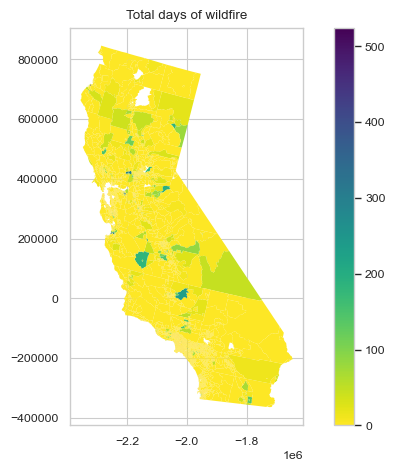

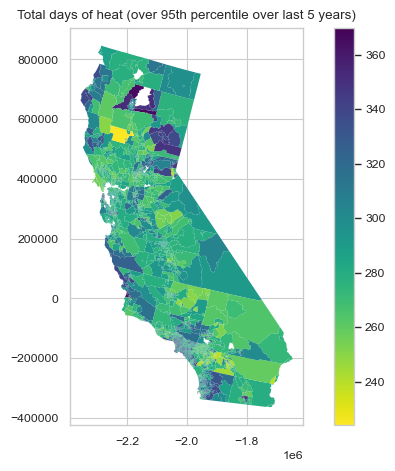

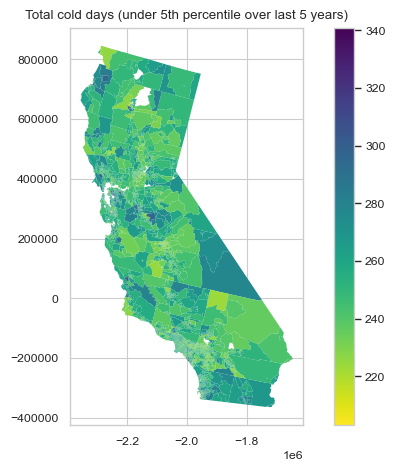

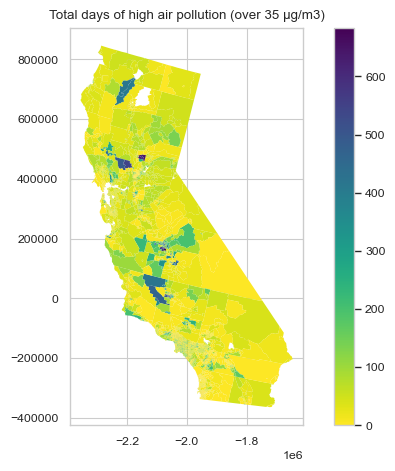

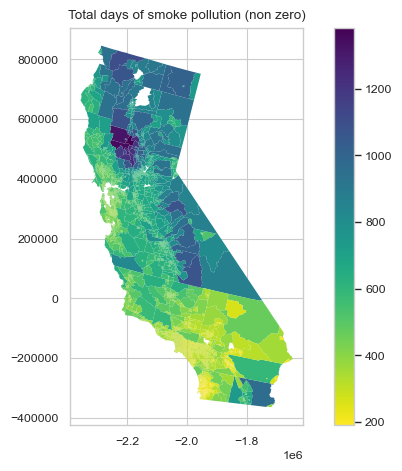

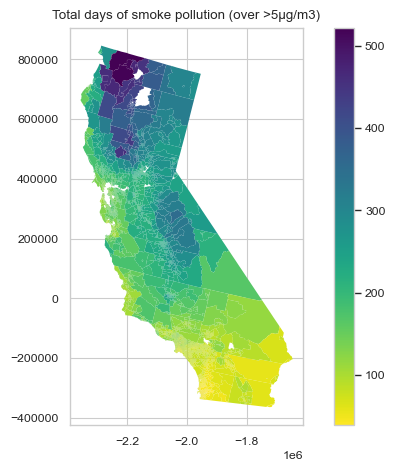

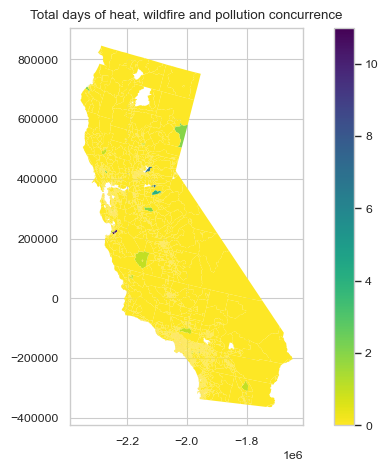

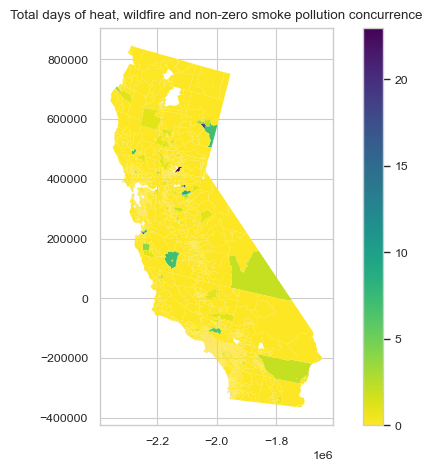

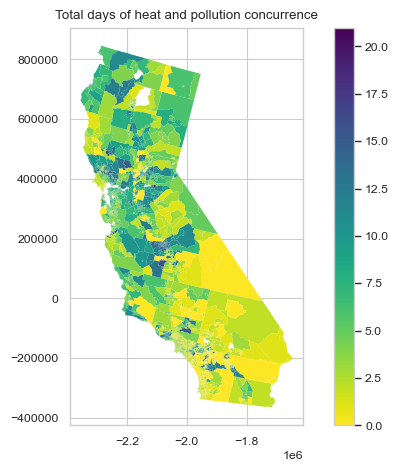

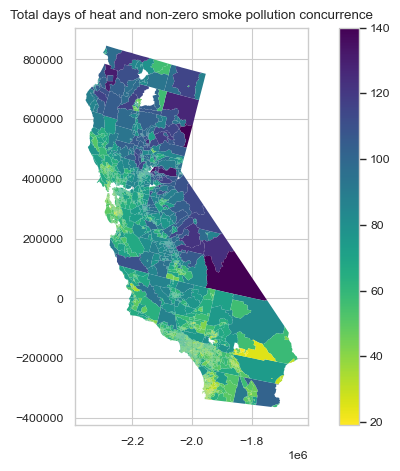

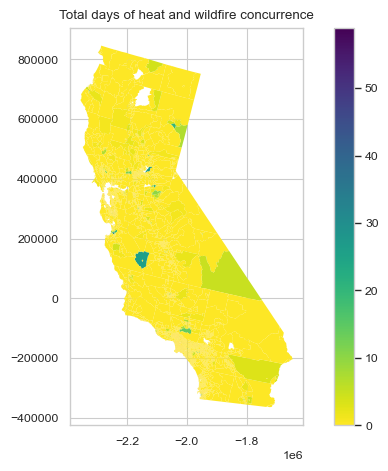

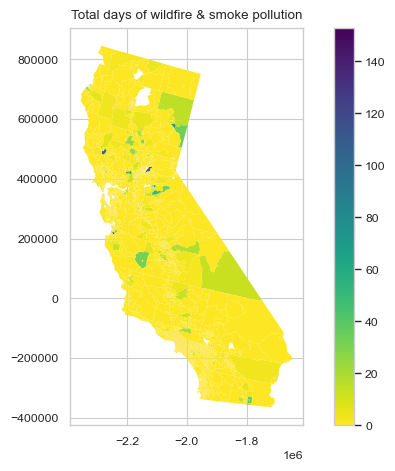

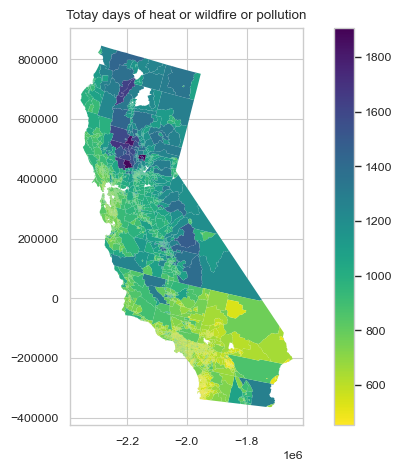

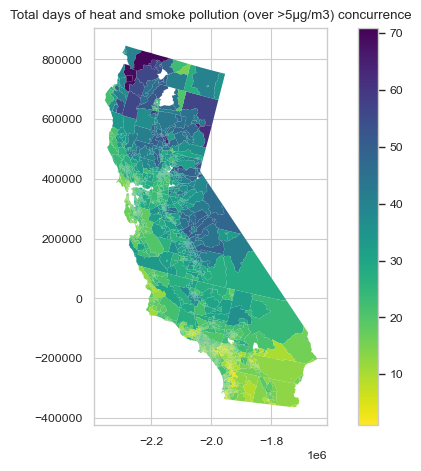

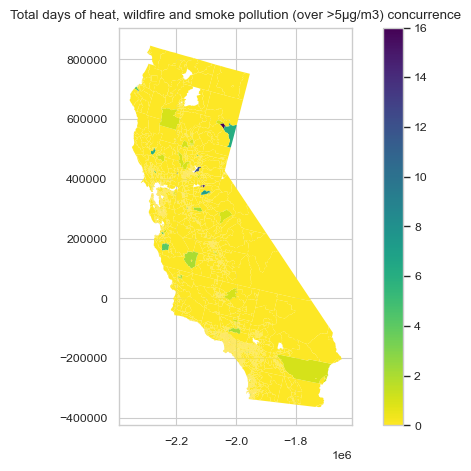

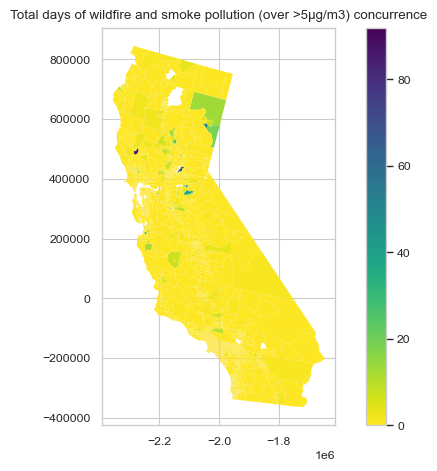

In [50]:
for x in hs_dict.keys():
    fig, ax = plt.subplots(1, 1)
    temp.plot(column=x, ax=ax, legend=True, linewidth=0, cmap="viridis_r")

    plt.title(hs_dict[x]["title_map"])
    plt.tight_layout()
    plt.savefig("figures/centract_hotspots_" + hs_dict[x]["title"] + ".png")
    plt.show()

## Add Vunerability Index

In [59]:
cols = [
    "STCNTY",
    "FIPS",
    "E_AFAM",
    "EP_AFAM",
    "E_TOTPOP",
    "EP_POV150",
    "EP_UNEMP",
    "EP_AGE65",
    "RPL_THEMES",
]
vind = pd.read_csv("data/California.csv", usecols=cols, dtype={"FIPS": str})
vind = vind[vind["RPL_THEMES"] > -1]

In [60]:
vind.head()

,STCNTY,FIPS,E_TOTPOP,EP_POV150,EP_UNEMP,EP_AGE65,RPL_THEMES,E_AFAM,EP_AFAM
0,6001,06001400100,3035,6.8,1.0,25.3,0.0255,94,3.1
1,6001,06001400200,1983,7.0,7.9,21.7,0.1978,44,2.2
2,6001,06001400300,5058,8.6,3.4,16.4,0.3560,433,8.6
3,6001,06001400400,4179,12.0,2.5,10.8,0.1596,278,6.7
4,6001,06001400500,4021,12.8,6.4,15.1,0.1312,1101,27.4


In [61]:
import geopandas as gpd

In [62]:
census_tracts = gpd.read_file(
    "data/shapefiles/tl_2020_06_tract/tl_2020_06_tract.shp", dtype={"GEOID": int}
)

In [63]:
df = census_tracts.merge(vind, left_on="GEOID", right_on="FIPS")

In [64]:
for a in df.columns:
    print(a)

STATEFP
COUNTYFP
TRACTCE
GEOID
NAME
NAMELSAD
MTFCC
FUNCSTAT
ALAND
AWATER
INTPTLAT
INTPTLON
geometry
STCNTY
FIPS
E_TOTPOP
EP_POV150
EP_UNEMP
EP_AGE65
RPL_THEMES
E_AFAM
EP_AFAM


In [65]:
varsdict = {
    "EP_POV150": "Persons below 150% poverty estimate (%)",
    "EP_UNEMP": "Civilian (16+) unemployed estimate (%)",
    "EP_AGE65": "Persons aged 65 or older (%)",
    "EP_AFAM": "Black African-American",
}
pallete = {
    "EP_POV150": "pink_r",
    "EP_UNEMP": "summer_r",
    "EP_AGE65": "winter_r",
    "EP_AFAM": "cool",
}  # 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool','Wistia'

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_36628/2880580489.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


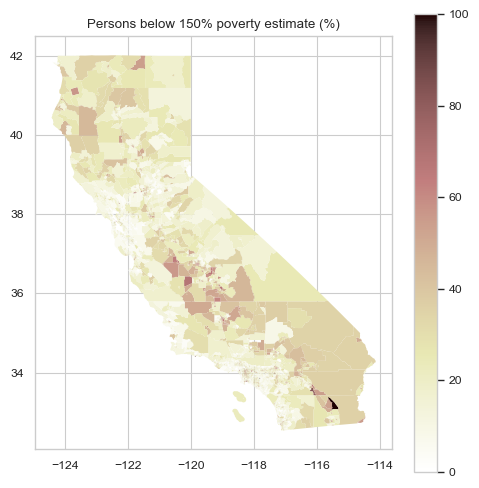

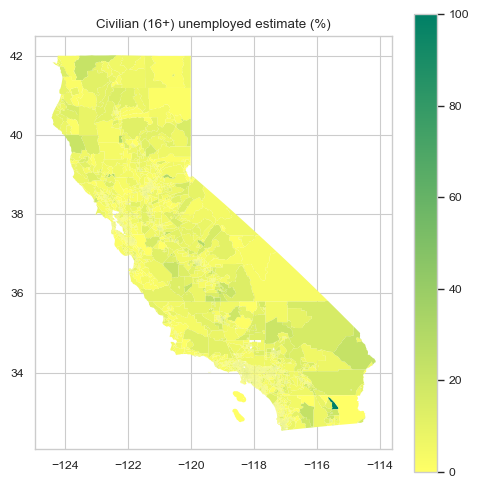

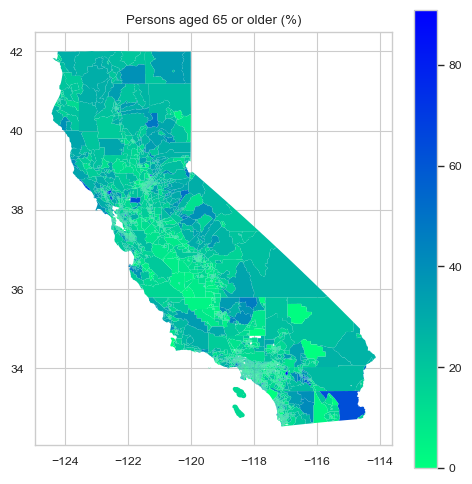

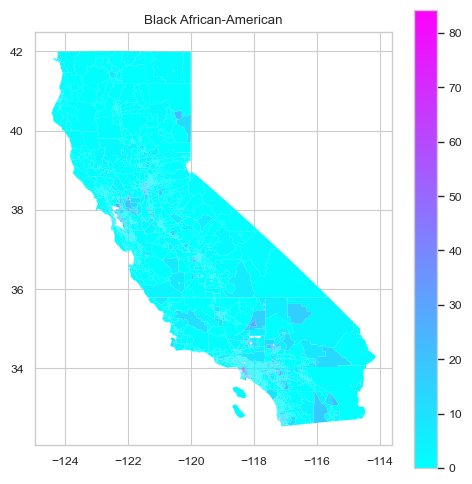

In [67]:
for var in varsdict.keys():
    # Plot the map with a specified column and color palette
    ax = df.plot(
        column=var, cmap=pallete[var], figsize=(5, 5), linewidth=0, edgecolor="black"
    )

    # Add a color bar to the plot
    sm = plt.cm.ScalarMappable(
        cmap=pallete[var], norm=plt.Normalize(vmin=df[var].min(), vmax=df[var].max())
    )
    sm.var = []
    cbar = plt.colorbar(sm)
    plt.title(varsdict[var])
    plt.tight_layout()
    plt.savefig(varsdict[var])
    plt.show()

In [69]:
vind.columns

Index(['STCNTY', 'FIPS', 'E_TOTPOP', 'EP_POV150', 'EP_UNEMP', 'EP_AGE65',
       'RPL_THEMES', 'E_AFAM', 'EP_AFAM'],
      dtype='object')

### Window of 7 days

Hotspot is if all three events happened within 7 days

In [ ]:
df = pd.read_parquet("outputs/merged_heatday_coldday_wfday_polluted_smoke_polluted.parquet")

In [ ]:
df = df.drop(columns = ['tmin','tmax','pm25','smokePM_pred'])

In [ ]:
df = df.reset_index()

In [ ]:
df.set_index('time', inplace=True)

In [ ]:
df.head()

In [ ]:
# create a new column that indicates if all three variables are True in the last 7 days
df['all_true_last_7_days'] = df[["wfday","heatday","smoke_polluted"]].rolling(
    window='7D', min_periods=1).max().sum(axis=1).apply(lambda x: True if x == 3.0 else False)

In [ ]:
df.head()

In [ ]:
df["all_true_last_7_days"].sum()